In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


 # Task -- Diagnostics
 In the first homework, we had two issues with the classifiers we built. Namely (1) the data were not shuffled, and (2) the labels were highly imbalanced. Both of these made it difficult to effectively build an accurate classifier. Here we’ll try and correct for those issues using the Bankruptcy dataset.

 ## Problem 1
 Download and parse the bankruptcy data. We’ll use the 5year.arff file. Code to read the data is available in the stub. Train a logistic regressor (e.g. sklearn.linear model.LogisticRegression) with regularization coefficient C = 1.0. Report the accuracy and Balanced Error Rate (BER) of your classifier (1 mark).

In [61]:
# ============ Environment Setup ============
# ignore the warnings
import warnings
warnings.filterwarnings("ignore")
# import some packages
from sklearn import linear_model
from sklearn.metrics import accuracy_score
import numpy as np

# Read the dataset
def myReadData(path): 
    f = open(path, 'r')
    while not '@data' in f.readline():
        pass
    dataset = []
    for l in f:
        if '?' in l: # Missing entry
            continue
        l = l.split(',')
        values = [1] + [float(x) for x in l]
        values[-1] = values[-1] > 0 # Convert to bool
        dataset.append(values)

    # Data setup
    X = [values[:-1] for values in dataset]
    y = [values[-1] for values in dataset]

    return X, y

def myEvaluation(model, X, y):
    # get predictions from model
    pred = model.predict(X)
    
    TP_ = np.logical_and(pred, y)
    FP_ = np.logical_and(pred, np.logical_not(y))
    TN_ = np.logical_and(np.logical_not(pred), np.logical_not(y))
    FN_ = np.logical_and(np.logical_not(pred), y)

    TP = sum(TP_)
    FP = sum(FP_)
    TN = sum(TN_)
    FN = sum(FN_)

    # Accuracy
    correct = pred == y
    print("Accuracy: %.2f" % np.mean(correct))
    # BER
    print("Balanced Error Rate: %.2f" %  (1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))))

X, y = myReadData("./Homework2/data/5year.arff")
# define a logistic regression
model = linear_model.LogisticRegression(C=1.0)
# fit a model
model.fit(X, y)
myEvaluation(model, X, y)


Accuracy: 0.97
Balanced Error Rate: 0.48


 ## Problem 3
 Shuffle the data, and split it into training, validation, and test splits, with a 50/25/25% ratio. Using the class weight=’balanced’ option, and training on the training set, report the training/validation/test accuracy and BER (1 mark).

In [62]:
# import packages
import random
random.seed(5583)

def myShuffle(X, y):
    """ Shuffle the data """
    Xy = list(zip(X,y))
    random.shuffle(Xy)
    X = [d[0] for d in Xy]
    y = [d[1] for d in Xy]
    return X, y

# Train/validation/test splits
def mySplits(X, y):
    N = len(y)

    Ntrain = int(0.5*len(y))
    Nvalid = int(0.25*len(y))
    Ntest = int(0.25*len(y))

    Xtrain = X[:Ntrain]
    Xvalid = X[Ntrain:Ntrain+Nvalid]
    Xtest = X[Ntrain+Nvalid:]

    ytrain = y[:Ntrain]
    yvalid = y[Ntrain:Ntrain+Nvalid]
    ytest = y[Ntrain+Nvalid:]

    return Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest

X, y = myReadData("./Homework2/data/5year.arff")
X, y = myShuffle(X, y)
Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest = mySplits(X, y)
# define a logistic regression
model = linear_model.LogisticRegression(C=1.0, class_weight='balanced')
# fit a model
model.fit(Xtrain, ytrain)
print("=============== Training ===============")
myEvaluation(model, Xtrain, ytrain)    # myEvaluation function was defined in Problem 1 
print("=============== Validating ===============")
myEvaluation(model, Xvalid, yvalid)
print("=============== Testing ===============")
myEvaluation(model, Xtest, ytest)



=============== Training ===============
Accuracy: 0.78
Balanced Error Rate: 0.24
=============== Validating ===============
Accuracy: 0.78
Balanced Error Rate: 0.20
=============== Testing ===============
Accuracy: 0.78
Balanced Error Rate: 0.26


 ## Problem 4
 Implement a complete regularization pipeline with the balanced classifier. Consider values of C in the range $\{10^{−4},10^{−3},...,10^3,10^4\}$. Report (or plot) the train, validation, and test BER for each value of C. Based on these values, which classifier would you select (in terms of generalization performance) and why (1 mark)?

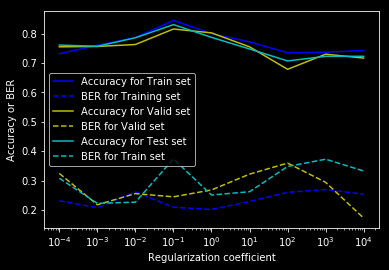

In [63]:
import matplotlib.pyplot as plt

def myEvaluation(model, X, y, acc, ber):
    # get predictions from model
    pred = model.predict(X)
    
    TP_ = np.logical_and(pred, y)
    FP_ = np.logical_and(pred, np.logical_not(y))
    TN_ = np.logical_and(np.logical_not(pred), np.logical_not(y))
    FN_ = np.logical_and(np.logical_not(pred), y)

    TP = sum(TP_)
    FP = sum(FP_)
    TN = sum(TN_)
    FN = sum(FN_)

    correct = pred == y
    # Accuracy
    acc.append(np.mean(correct))
    # BER
    ber.append(1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP)))
    return acc, ber

def regPipeline(X, y, reg, trainAcc, trainBer, validAcc, validBer, testAcc, testBer):
    X, y = myShuffle(X, y)
    Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest = mySplits(X, y)
    model = linear_model.LogisticRegression(C=reg, class_weight='balanced')
    # fit a model
    model.fit(Xtrain, ytrain)
    trainAcc, trainBer = myEvaluation(model, Xtrain, ytrain, trainAcc, trainBer)
    validAcc, validBer = myEvaluation(model, Xvalid, yvalid, validAcc, validBer)
    testAcc, testBer = myEvaluation(model, Xtest, ytest, testAcc, testBer)
    return trainAcc, trainBer, validAcc, validBer, testAcc, testBer

trainAcc, trainBer, validAcc, validBer, testAcc, testBer = [], [], [], [], [], []
regs = [10**N for N in [-4, -3, -2, -1, 0, 1, 2, 3, 4]]
for reg in regs:
    X, y = myReadData("./Homework2/data/5year.arff")
    trainAcc, trainBer, validAcc, validBer, testAcc, testBer = regPipeline(X, y, reg, trainAcc, trainBer, validAcc, validBer, testAcc, testBer)

plt.plot(regs, trainAcc, 'b-', label='Accuracy for Train set')
plt.plot(regs, trainBer, 'b--', label='BER for Training set')
plt.plot(regs, validAcc, 'y-', label='Accuracy for Valid set')
plt.plot(regs, validBer, 'y--', label='BER for Valid set')
plt.plot(regs, testAcc, 'c-', label='Accuracy for Test set')
plt.plot(regs, testBer, 'c--', label='BER for Train set')
plt.legend()
plt.xlabel('Regularization coefficient')
plt.xscale('log')
plt.ylabel('Accuracy or BER')
plt.show()



 Based on the plot, we will choose $10^0$ since it has the lowest BER for the validation set and meanwhile keeps a high accuracy on both the training and validation set.

 ## Problem 6
 The sample weight option allows you to manually build a balanced (or imbalanced) classifier by assigning different weights to each datapoint (i.e., each label y in the training set). For example, we would assign equal weight to all samples by fitting:

 weights = [1.0] * len(ytrain)

 mod = linear_model.LogisticRegression(C=1, solver=’lbfgs’)

 mod.fit(Xtrain, ytrain, sample_weight=weights)

 (note that you should use the lbfgs solver option, and need not set class weight=’balanced’ in
 this case). Assigning larger weights to (e.g.) positive samples would encourage the logistic regressor to
 optimize for the True Positive Rate. Using the above code, compute the Fβ score (on the test set) of your
 (unweighted) classifier, for β = 1 and β = 10. Following this, identify weight vectors that yield better
 performance (compared to the unweighted vector) in terms of the F1 and F10 scores (2 marks).

In [64]:
def FBeta(model, Xtest, ytest, beta):
    pred = model.predict(Xtest)
    retrieved = sum(pred)
    relevant = sum(ytest)
    intersection = sum([y and p for y, p in zip(ytest,pred)])
    precision = intersection / retrieved
    recall = intersection / relevant
    F_Beta = (1+beta**2)*(precision*recall)/((beta**2)*(precision+recall))
    print("=============== For Beta %d =============== " % beta)
    print("F Score is %.2f" % F_Beta)

X, y = myReadData("./Homework2/data/5year.arff")
X, y = myShuffle(X, y)
Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest = mySplits(X, y)
weights = [1.0] * len(ytrain)
model = linear_model.LogisticRegression(C=1.0, solver='lbfgs')
model.fit(Xtrain, ytrain, sample_weight=weights)
FBeta(model, Xtest, ytest, 1)
FBeta(model, Xtest, ytest, 10)
# nan?

# ?
weights = [1.0 if y is True else -1.0 for y in ytrain]
model = linear_model.LogisticRegression(C=1.0, solver='lbfgs')
model.fit(Xtrain, ytrain, sample_weight=weights)
FBeta(model, Xtest, ytest, 1)
FBeta(model, Xtest, ytest, 10)



=============== For Beta 1 =============== 
F Score is 0.08
=============== For Beta 10 =============== 
F Score is 0.04
=============== For Beta 1 =============== 
F Score is 0.04
=============== For Beta 10 =============== 
F Score is 0.02


 # Tasks -- Dimensionality Reduction
 Next we’ll consider using PCA to build a lower-dimensional feature vector to do prediction.

 ## Problem 7
 Following the stub code, compute the PCA basis on the training set. Report the first PCA component
 (i.e., pca.components [0])

In [65]:
from sklearn.decomposition import PCA

X, y = myReadData("./Homework2/data/5year.arff")
X, y = myShuffle(X, y)
Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest = mySplits(X, y)
pca = PCA(n_components=5)
pca.fit(Xtrain)
print(pca.components_[0])


[-2.49269701e-25 -1.32986571e-08  8.69477220e-08  9.66240363e-07
  3.53612346e-06  1.90155045e-03 -3.98755783e-07  1.35488653e-06
  4.78864782e-06 -7.57076010e-07  5.83248404e-08  2.04141910e-07
  1.24332124e-06 -4.63090744e-06  1.35456531e-06 -6.79391590e-04
  1.02326976e-06  5.24938747e-06  1.23650135e-06  4.23571734e-07
  1.83211752e-05 -1.18174042e-05  1.69555550e-07  3.80510136e-07
  8.83831300e-07  7.04348958e-07  9.00985037e-07 -8.71863444e-05
  2.08046420e-06  3.55281807e-06 -1.78536547e-06  4.13490614e-07
 -4.76901855e-04  3.80692788e-06 -1.74752667e-06  1.41523324e-07
 -7.30140948e-07  8.12700417e-04 -3.54749596e-07  1.29341450e-07
  1.66423150e-06 -6.03200207e-06  2.47656664e-07  1.28730644e-05
 -5.45050111e-06 -2.36634867e-06  2.69938247e-06 -3.03683066e-04
  2.06870776e-07  3.63631540e-07  3.45477277e-06 -7.17982563e-07
 -1.27340380e-06 -3.61485664e-06  2.05849898e-06  9.99997429e-01
  1.52019732e-07 -1.26002651e-07 -2.62204292e-07  3.97744418e-07
 -1.55928456e-04 -9.89525

 ## Problem 8
 Next we’ll train a model using a low-dimensional feature vector. By representing the data in the above
 basis, i.e.:

 Xpca_train = numpy.matmul(Xtrain, pca.components_.T)

 Xpca_valid = numpy.matmul(Xvalid, pca.components_.T)

 Xpca_test = numpy.matmul(Xtest, pca.components_.T)

 compute the validation and test BER of a model that uses just the first N components (i.e., dimensions) for N = 5, 10, ... , 25, 30. Again use class weight=’balanced’ and C = 1.0 (2 marks).

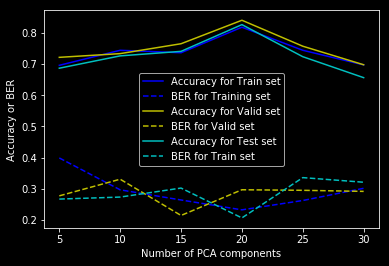

In [66]:
def getLowDimension(N, Xtrain, Xvalid, Xtest):
    pca = PCA(n_components=N)
    pca.fit(Xtrain)
    Xpca_train = numpy.matmul(Xtrain, pca.components_.T) 
    Xpca_valid = numpy.matmul(Xvalid, pca.components_.T) 
    Xpca_test = numpy.matmul(Xtest, pca.components_.T)
    return Xpca_train, Xpca_valid, Xpca_test

def regPipeline(Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest, trainAcc, trainBer, validAcc, validBer, testAcc, testBer):
    model = linear_model.LogisticRegression(C=1.0, class_weight='balanced')
    model.fit(Xtrain, ytrain)
    trainAcc, trainBer = myEvaluation(model, Xtrain, ytrain, trainAcc, trainBer)
    validAcc, validBer = myEvaluation(model, Xvalid, yvalid, validAcc, validBer)
    testAcc, testBer = myEvaluation(model, Xtest, ytest, testAcc, testBer)
    return trainAcc, trainBer, validAcc, validBer, testAcc, testBer

trainAcc, trainBer, validAcc, validBer, testAcc, testBer = [], [], [], [], [], []
Ns = list(range(5, 35, 5))
for N in Ns:
    X, y = myReadData("./Homework2/data/5year.arff")
    X, y = myShuffle(X, y)
    Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest = mySplits(X, y)
    Xtrain, Xvalid, Xtest = getLowDimension(N, Xtrain, Xvalid, Xtest)
    trainAcc, trainBer, validAcc, validBer, testAcc, testBer = regPipeline(Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest, trainAcc, trainBer, validAcc, validBer, testAcc, testBer)

plt.plot(Ns, trainAcc, 'b-', label='Accuracy for Train set')
plt.plot(Ns, trainBer, 'b--', label='BER for Training set')
plt.plot(Ns, validAcc, 'y-', label='Accuracy for Valid set')
plt.plot(Ns, validBer, 'y--', label='BER for Valid set')
plt.plot(Ns, testAcc, 'c-', label='Accuracy for Test set')
plt.plot(Ns, testBer, 'c--', label='BER for Train set')
plt.legend()
plt.xlabel('Number of PCA components')
plt.ylabel('Accuracy or BER')
plt.show()

